# Assignment 3: Convolutional neural networks for classification

The goal of this assignment is to demonstrate the Keras API for implementing and training convolutional neural network architectures. Furthermore, you get to work with the PatchCAMELYON (or PCAM) dataset that you should also use for the main project work. Essentially, this assignment demonstrated a minimal working example for the main project work.

### Preliminaries

The full working code of the example convolutional neural network can be found in the `cnn.py` file. As before, we will go over the components of the code in this Python notebook, however, you are strongly encouraged to perform all experiments using `cnn.py`. We start with importing the required libraries and defining the size of the images in the PCAM dataset.


In [24]:
import winsound

import os

import numpy as np
import matplotlib.pyplot as plt
import json

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import tensorflow


# unused for now, to be used for ROC analysis
from sklearn.metrics import roc_curve, auc


# the size of the images in the PCAM dataset
IMAGE_SIZE = 96

### Instantiating data generators

Compared to the MNIST dataset, the PatchCAMELYON dataset is too big to fit in the working memory of most personal computers. This is why, we need to define some functions that will read the image data batch by batch, so only a single batch of images needs to be stored in memory at one time point. We can use the handy ImageDataGenerator function from the Keras API to do this. Note that the generators are defined within a function that returns them as output arguments. This function will later be called from the main code body. 


In [25]:
def get_pcam_generators(base_dir, train_batch_size=32, val_batch_size=32):

     # dataset parameters
     TRAIN_PATH = os.path.join(base_dir, 'train+val', 'train')
     VALID_PATH = os.path.join(base_dir, 'train+val', 'valid')

     RESCALING_FACTOR = 1./255
     
     # instantiate data generators
     datagen = ImageDataGenerator(rescale=RESCALING_FACTOR)

     train_gen = datagen.flow_from_directory(TRAIN_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=train_batch_size,
                                             class_mode='binary')

     val_gen = datagen.flow_from_directory(VALID_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=val_batch_size,
                                             class_mode='binary',
                                             shuffle=False)
     
     return train_gen, val_gen

### Building a convolutional neural network classification model

The convolutional neural network model is also defined within a function. Organizing the code into functions instead of piling everything up in a single script makes the code more clear to read and understand, and helps reuse functionality that is already implemented. For example, we can use the `get_pcam_generators()` function to create data generators with different batch sizes just by calling the function with a different set of parameters. Or, we can use the `get_model()` function to generate networks with different number of feature maps (see below). 

The convolutional neural network model consists of two convolutional layers, each one followed by a max pooling layer and a fully connected layer with 64 neurons. The kernel size and number of filters of the two convolutional layers, and the size of the max pooling regions can be passed as input parameters to the function (however, note that default values are set so the function can be called without parameters). ReLU nonlinearities are used throughout the network, except for the output neuron that is activated with a sigmoid. 

In [26]:
def get_model(kernel_size=(3,3), pool_size=(4,4), first_filters=32, second_filters=64):


     # build the model
     model = Sequential()

     model.add(Conv2D(first_filters, kernel_size, activation = 'relu', padding = 'same', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
     model.add(MaxPool2D(pool_size = pool_size)) 

     model.add(Conv2D(second_filters, kernel_size, activation = 'relu', padding = 'same'))
     model.add(MaxPool2D(pool_size = pool_size))

     model.add(Flatten())
     model.add(Dense(64, activation = 'relu'))
     model.add(Dense(1, activation = 'sigmoid'))
     
    
     # compile the model
     model.compile(SGD(learning_rate=0.01, momentum=0.95), loss = 'binary_crossentropy', metrics=['accuracy'])

     return model

Now, the two functions that define the model and the data generators can be called from the main code body. Before executing the code block below, do not forget to change the path where the PatchCAMELYON dataset is located (that is, the location of the folder that contains `train+val` that you previously downloaded and unpacked).

If everything is correct, the following output will be printed on screen after executing the code block:

`Found 144000 images belonging to 2 classes.`

`Found 16000 images belonging to 2 classes.`

In [27]:
# get the model
model = get_model()

# get the data generators
train_gen, val_gen = get_pcam_generators(r'C:\Users\20192735\Documents\8P361_images')

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


If you want to know the shapes of the outputs of all layers in the network (the dimensionality of the feature maps), you can print them in the following way:

In [28]:
for layer in model.layers:
    print(layer.output_shape)

(None, 96, 96, 32)
(None, 24, 24, 32)
(None, 24, 24, 64)
(None, 6, 6, 64)
(None, 2304)
(None, 64)
(None, 1)


### Training and evaluating the model

Finally, the model can be trained using data generated by the data generators and then evaluated. This is done in a similar way to the previous assignment. Furthermore, in addition to the Tensorflow callback, an additional callback that saves the "best" version of the trained model to a file is added, and the model structure is saved to a json file. This enables loading the model and corresponding weights at a later time point (e.g. when we want to evaluate the model on a test set). 

In [29]:
# save the model and weights
model_name = 'my_first_cnn_model'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'

model_json = model.to_json() # serialize model to JSON
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json) 


# define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]


# train the model
train_steps = train_gen.n//train_gen.batch_size
val_steps = val_gen.n//val_gen.batch_size

history = model.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=3,
                    callbacks=callbacks_list)

Epoch 1/3
4500/4500 [==============================] - ETA: 0s - loss: 0.4579 - accuracy: 0.7855
Epoch 1: val_loss improved from inf to 0.40261, saving model to my_first_cnn_model_weights.hdf5
4500/4500 [==============================] - 987s 219ms/step - loss: 0.4579 - accuracy: 0.7855 - val_loss: 0.4026 - val_accuracy: 0.8268
Epoch 2/3
4500/4500 [==============================] - ETA: 0s - loss: 0.3614 - accuracy: 0.8423
Epoch 2: val_loss improved from 0.40261 to 0.32567, saving model to my_first_cnn_model_weights.hdf5
4500/4500 [==============================] - 386s 86ms/step - loss: 0.3614 - accuracy: 0.8423 - val_loss: 0.3257 - val_accuracy: 0.8587
Epoch 3/3
4500/4500 [==============================] - ETA: 0s - loss: 0.3245 - accuracy: 0.8615
Epoch 3: val_loss did not improve from 0.32567
4500/4500 [==============================] - 388s 86ms/step - loss: 0.3245 - accuracy: 0.8615 - val_loss: 0.3280 - val_accuracy: 0.8565


In [30]:
#beep sound when run, to indicate finishing of code
winsound.Beep(1000,1000)

In case you are wondering why (for the first epochs in particular) the validation accuracy is much higher than the training accuracy and the validation loss is lower than the training loss, you can find your answer in the [Keras FAQ](https://keras.rstudio.com/articles/faq.html).

### Before you start with the exercises...

Make sure that you understand all new code components introduced in the example. Remember: you can always lookup the documentation of the used functions to get a better understanding about how they work.

[This blog post](http://karpathy.github.io/2019/04/25/recipe/) by Andrej Kaprapthy with tips and tricks for training neural networks is highly recommended reading material.

## Exercise 1

The PatchCAMELYON challenge on Kaggle uses the area under the ROC curve as an evaluation measure. Describe the concept of ROC curve analysis and the area under the ROC curve (AUC) as an evaluation measure. Then, using methods from the sklearn Python toolbox (the required functions are alerady imported), perform ROC curve analysis and computation of the AUC for your model. 

Note that you will have to do this analysis on the validation set (since you do not have access to the ground truth for the test set). 

In [31]:
model = tensorflow.keras.models.load_model(r'C:\Users\20192735\OneDrive - TU Eindhoven\8P361 - Project Imaging\8p361-project-imaging-master\assignments\my_first_cnn_model_weights.hdf5')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 2304)              0         
                                                                 
 dense_5 (Dense)             (None, 64)               

In [32]:
y_pred_keras=model.predict(val_gen).ravel()

y_true = val_gen.labels

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred_keras)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

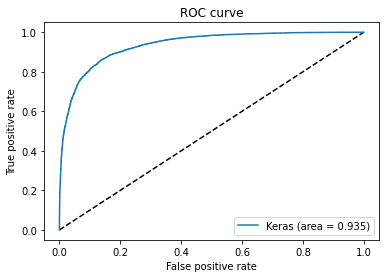

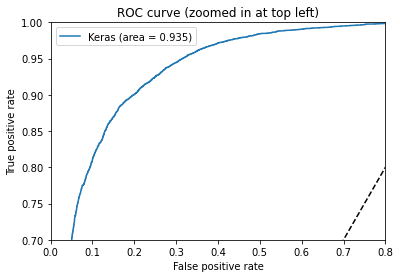

In [33]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.8)
plt.ylim(0.7, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

<b>Describe the concept of ROC curve analysis and the area under the ROC curve (AUC) as an evaluation measure</b><br>
An ROC curve can be considered as the average value of the sensitivity for a test over all possible values of specificity or vice versa. The ROC curve thus gives an idea of the performance of the model. [1]

The area under the ROC curve (AUC) is an effective way to summarize the overall diagnostic accuracy of the test. The AUC gives an indication of how well the model can discriminate inputs for being disease or no disease. An AUC of 0.5 suggests no discrimination. Values from 0.7 to 1 are considered acceptable to outstanding. [1]


[1] Mandrekar, J., 2022. Receiver Operating Characteristic Curve in Diagnostic Test Assessment.

## Exercise 2

It is possible to construct a neural network model that is equivalent to the model above, however, only using convolutional layers (i.e. without using any fully connected or "dense" layers). Construct and train such a model. 

In [38]:
def get_model2(kernel_size=(3,3), pool_size=(4,4), first_filters=32, second_filters=64):


     # build the model
     model = Sequential()

     model.add(Conv2D(first_filters, kernel_size, activation = 'relu', padding = 'same', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
     model.add(MaxPool2D(pool_size = pool_size)) 

     model.add(Conv2D(second_filters, kernel_size, activation = 'relu', padding = 'same'))
     model.add(MaxPool2D(pool_size = pool_size))
     model.add(Conv2D(64, [6,6], activation = 'relu', padding = 'valid'))
     model.add(Conv2D(1,[1,1],activation='sigmoid', padding='same'))
    
     # compile the model
     model.compile(SGD(learning_rate=0.01, momentum=0.95), loss = 'binary_crossentropy', metrics=['accuracy'])
     model.add(Flatten())

     return model
    
model2 = get_model2()
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 1, 1, 64)          147520    
                                                                 
 conv2d_15 (Conv2D)          (None, 1, 1, 1)          

In [35]:
for layer in model2.layers:
    print(layer.output_shape)

(None, 96, 96, 32)
(None, 24, 24, 32)
(None, 24, 24, 64)
(None, 6, 6, 64)
(None, 1, 1, 64)
(None, 1, 1, 1)
(None, 1)


In [36]:
# save the model and weights
model_name = 'cnn_no_dense_layer'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'

model_json = model2.to_json() # serialize model to JSON
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json) 


# define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]


# train the model
train_steps = train_gen.n//train_gen.batch_size
val_steps = val_gen.n//val_gen.batch_size

history = model2.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=3,
                    callbacks=callbacks_list)

Epoch 1/3
4500/4500 [==============================] - ETA: 0s - loss: 0.4706 - accuracy: 0.7770
Epoch 1: val_loss improved from inf to 0.45770, saving model to cnn_no_dense_layer_weights.hdf5
4500/4500 [==============================] - 401s 89ms/step - loss: 0.4706 - accuracy: 0.7770 - val_loss: 0.4577 - val_accuracy: 0.7962
Epoch 2/3
4500/4500 [==============================] - ETA: 0s - loss: 0.4015 - accuracy: 0.8192
Epoch 2: val_loss improved from 0.45770 to 0.36071, saving model to cnn_no_dense_layer_weights.hdf5
4500/4500 [==============================] - 404s 90ms/step - loss: 0.4015 - accuracy: 0.8192 - val_loss: 0.3607 - val_accuracy: 0.8434
Epoch 3/3
4500/4500 [==============================] - ETA: 0s - loss: 0.3488 - accuracy: 0.8501
Epoch 3: val_loss improved from 0.36071 to 0.31953, saving model to cnn_no_dense_layer_weights.hdf5
4500/4500 [==============================] - 378s 84ms/step - loss: 0.3488 - accuracy: 0.8501 - val_loss: 0.3195 - val_accuracy: 0.8634


In [37]:
#beep sound when run, to indicate finishing of code
winsound.Beep(1000,1000)

<h3>What would be the advantage of only using convolutional layers?</h3>

<b>Generally</b> <br>
Convulation layers in combination with 2D max pooling layers reduce the dimensionality of the data. Layer for layer the data gets suppresed to a single value as output. Therefore, the model gets more simple than a model with dense layers.

Any dense layer could be replaced by a single convolution that would perform the same association of neighboring pixels for each pixel. A convolutional layer is enforcing parameter sharing: the processing of each pixel is identical by design, not by learning. Resulting in a dramatic reduction in the number of parameters to learn. [1] Which decreases the time the model needs for training and result output. 

This in combination with the model structure of a convolutional model, in which pixel intensities come forth from known locations in previous layers, makes the model easier interpretable than a model with dense layers.

<b>In this specific case</b><br>
As neurons in a convolutional layer are only connected to neurons that are close to the neurons from the previous layers (with the size of the kernel), the neurons from a convolutional layer are therefore more narrow in the range of features, because they are insenstive to most of the neurons in the preceding layer.

[1] Hue, A., 2022. Dense or Convolutional — Part-1. [online] Medium. Available at: <https://medium.com/analytics-vidhya/dense-or-convolutional-part-1-c75c59c5b4ad> [Accessed 26 February 2022].

## Exercise 3

Use the `kaggle_submission.py` file to prepare and submit results for evaluation to Kaggle. What is the result of the evaluation on the test set? How does it compare to the evaluation that you performed on the validation set?

In [44]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}   
import tensorflow as tf

import numpy as np

import glob
import pandas as pd
from matplotlib.pyplot import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import model_from_json

#Change these variables to point at the locations and names of the test dataset and your models.
TEST_PATH = 'C:/Users/20192735/Documents/8P361_images/test/**/' 
MODEL_FILEPATH = r'C:\Users\20192735\OneDrive - TU Eindhoven\8P361 - Project Imaging\8p361-project-imaging-master\assignments\cnn_no_dense_layer.json' 
MODEL_WEIGHTS_FILEPATH = r'C:\Users\20192735\OneDrive - TU Eindhoven\8P361 - Project Imaging\8p361-project-imaging-master\assignments\cnn_no_dense_layer_weights.hdf5'

# load model and model weights
json_file = open(MODEL_FILEPATH, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)


# load weights into new model
model.load_weights(MODEL_WEIGHTS_FILEPATH)


# open the test set in batches (as it is a very big dataset) and make predictions
test_files = glob.glob(TEST_PATH + '*.tif')


submission = pd.DataFrame()

file_batch = 5000
max_idx = len(test_files)

for idx in range(0, max_idx, file_batch):

    print('Indexes: %i - %i'%(idx, idx+file_batch))

    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]})


    # get the image id 
    test_df['id'] = test_df.path.map(lambda x: x.split(os.sep)[-1].split('.')[0])
    test_df['image'] = test_df['path'].map(imread)
    
    
    K_test = np.stack(test_df['image'].values)
    
    # apply the same preprocessing as during draining
    K_test = K_test.astype('float')/255.0
    
    predictions = model.predict(K_test)
    
    test_df['label'] = predictions
    submission = pd.concat([submission, test_df[['id', 'label']]])


# save your submission
submission.head()
submission.to_csv('submission.csv', index = False, header = True)

<b>Evaluation</b> <br>
The submission on Kaggle gives us a score of 0.8529 for the model without dense layers. 

In comparison with the model where dense layers are used in the same structure, the score is Score: 0.8551. 
The only convolutional layer model thus scores 0.0022 lower than its dense layer using competitor.

Comparing the Kaggle submission, thus test set accuracy, with the validation accuracy which we performed ourselves (both from the model without dense layers). The validation accuracy is 0.0105 higher with a score of 0.8634.

## Submission checklist

* Exercise 1: Answer to the questions and code
* Exercise 2: Answer to the questions and code
* Exercise 3: Answer to the questions and code